## Setting up metadata for Mobile Seismoacoustic Array (MSA) & interaction with NRL

Author: Jelle Assink (jelle.assink@knmi.nl)

This code is distributed under the terms of the
GNU General Public License, Version 3
(https://www.gnu.org/licenses/gpl-3.0.en.html)

# Import packages

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 125

In [2]:
from obspy.core.inventory.util import Site
from obspy.core.inventory import Station
from obspy.clients.nrl import NRL
from obspy import UTCDateTime

In [3]:
from pysametadata.core.metadata import Metadata
from pysametadata.sensors.hyperion import IFS5000
from pysametadata.sensors.ion import SM6
from pysametadata.dataloggers.kinemetrics import Obsidian

In [4]:
import numpy as np

# Setting up the basis of an `Metadata` object

As an example, metadata will be prepared for the first element of KNMI's Mobile Seismo-acoustic Array (MSA), i.e. NL.MSA01.

The first step is define the inventory and network attributes and describe the site information.

In [5]:
NL_MSA = Metadata(code='NL', name='MSA01', institute='KNMI',
                  description='Royal Netherlands Meteorological Institute')
NL_MSA.set_network(code=NL_MSA.code,
                   description='Netherlands Seismic and Acoustic Network',
                   starttime=UTCDateTime('1993-01-01T00:00:00'))
net = NL_MSA.network
NL_MSA.inventory.networks.append(NL_MSA.network)

In [6]:
site_info = Site('Mobile Seismoacoustic Array 0 - Element 1 (MSA01)',
                 description='Mobile Seismoacoustic Array',
                 town='De Bilt', country='The Netherlands')

Once an Obspy `Network` object is defined, a `Station` object can be added, so in this example station `NL.MSA01`:

In [7]:
net.stations.append(Station('MSA01', 52.09989, 5.17647, 0.0, vault=0.0))

Now the description of the site and its opening time can be added:

In [8]:
sta = net[0]
t0 = UTCDateTime('2020-06-26T14:00:00')
NL_MSA.set_station(sta, site_info, starttime=t0)
print(sta)

Station MSA01 (Mobile Seismoacoustic Array 0 - Element 1 (MSA01))
	Station Code: MSA01
	Channel Count: None/None (Selected/Total)
	2020-06-26T14:00:00.000000Z - 
	Access: open Alternate Code: MSA01 
	Latitude: 52.10, Longitude: 5.18, Elevation: 0.0 m
	Available Channels:



# Setting up response information from home-made metadata classes

The set-up of `NL.MSA01` consists of a Hyperion IFS-5111 infrasound microphone and a 3-component 4.5 Hz 375 Ohm SM-6 geophone by Sensor B.V. / IONgeo. The data is logged by a [Kinemetrics Obsidian datalogger](https://kinemetrics.com/post_products/obsidian/). The sensitivity and response information of these instruments are provided by the `Hyperion`, `SM6` and `Obsidian` classes that are part of `pysametadata`.
 
The sensitivity of the Hyperion IFS-5111 has been determined to be approximately 140 mV/Pa. The sensitivity of the SM6 is effectively 27.6 V / m/s.

The Obsidian datalogger is configured with a sample rate of 100 Hz and has variable full-scale voltage up to 20 V, meaning that voltages between -20 V and +20 V can be facilitated. As the datalogger in theory has 24 bits available, this means that $2^{24}$ counts are to be divided over the voltage range.

In our setup the voltage range of the three geophone channels is 5 Vpp (i.e. voltages may range between -2.5 and 2.5 V). The voltage range for the microbarometer is 40 Vpp. The difference is related to the expected sensor output: the geophones provide much smaller sensor outputs when compared to the microbarometer, and therefore it is better to tune the digitiser to have a higher gain.

In summary, the following four channels form `NL.MSA01`:

In [9]:
channels = {}
channels['HHE'] = {'dip':     0, 'azimuth': 90.0}
channels['HHN'] = {'dip':     0, 'azimuth': 0.0}
channels['HHZ'] = {'dip':   -90, 'azimuth': 0.0}
channels['HDF'] = {'dip': False, 'azimuth': False}

The channels of `NL.MSA01` can now be configured as follows:

In [10]:
for cha in channels.keys():
    if cha == 'HDF':
        # Infrasound channel
        channel = NL_MSA.set_channel(cha, sta, sample_rate=200.0,
                                     starttime=t0)
        my_sensor = IFS5000(channel)
        my_sensor.set_response(stage=1)
        my_logger = Obsidian(channel, V_max=20.0,
                             sens_freq=my_sensor.sens_freq,
                             serial_number=1254)
        my_logger.set_response(stage=2)
    else:
        # Seismic channels
        channel = NL_MSA.set_channel(cha, sta, sample_rate=200.0,
                                     starttime=t0,
                                     dip=channels[cha]['dip'],
                                     azimuth=channels[cha]['azimuth'])
        my_sensor = SM6(channel, model='SM-6 B 4.5 Hz 375 Ohm')
        my_sensor.set_response(stage=1)
        my_logger = Obsidian(channel, V_max=2.5,
                             sens_freq=my_sensor.sens_freq,
                             serial_number=1254)
        my_logger.set_response(stage=2)

    NL_MSA.calculate_sensitivity(channel)
    sta.channels.append(channel)

The constructed response can be reviewed and be plotted:

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26092e+07 defined at 10.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.35544e+06


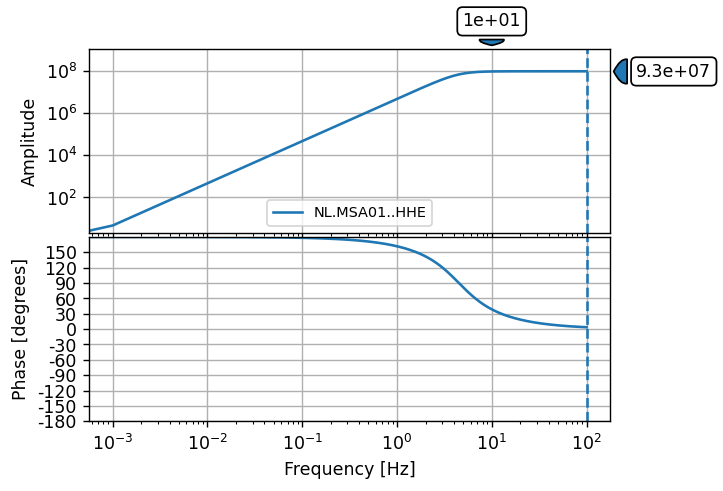

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26092e+07 defined at 10.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.35544e+06


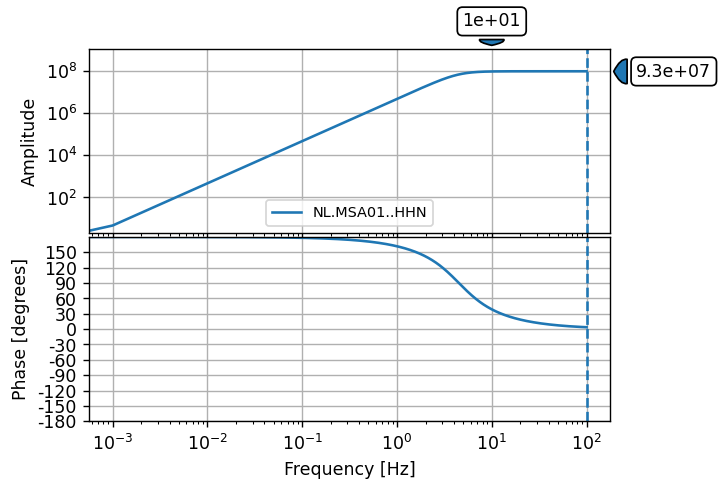

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26092e+07 defined at 10.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.35544e+06


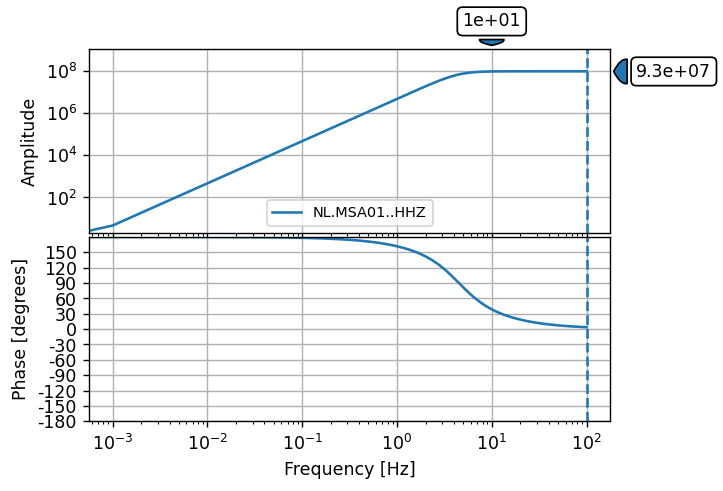

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 58720.3 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.14
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 419430


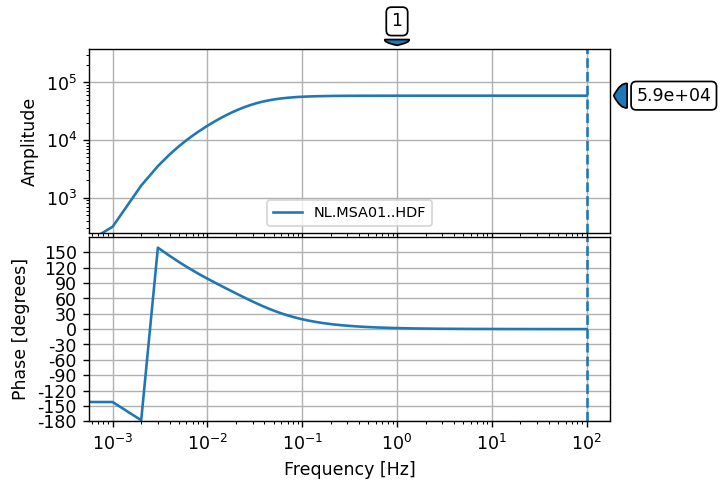

In [11]:
for cha in sta:
    print(cha.response)
    fig=cha.plot(1e-3, unwrap_phase=True, label=cha.seed_id, plot_degrees=True)

# Comparison with NRL Kinemetrics Obsidian response

Now, a new channel response is defined. The Hyperion and SM6 sensor responses and the common attributes of the Obsidian datalogger will be kept, but instead of using the 'home-made' Obsidian response (which is a simple flat line with a gain determined by the numbers of bits available and the full-scale voltage), now we are going to use the official response file that is provided by the Nominal Response Library (NRL). This response file also includes all the finite impulse response (FIR) digital filters that are part of the dataloggers.

The next step is to initialise ObsPy's built-in NRL client to connect to the online database.

In [12]:
nrl = NRL()

There are many response files available, depending on the settings of the datalogger. We'll configure the station to mimic our situation.

In [13]:
# infrasound channel
print(nrl.dataloggers['Kinemetrics']['Rock Family (Basalt, Granite, Dolomite, Obsidian)']['1']['40']['Non-causal']['200'])
# geophone channels
print(nrl.dataloggers['Kinemetrics']['Rock Family (Basalt, Granite, Dolomite, Obsidian)']['1']['5']['Non-causal']['200'])

('Rock family, gain 1, 40 Vpp, 200 sps, non-causal filter', 'http://ds.iris.edu/NRL/dataloggers/kinemetrics/rock/RESP.XX.NK355..HHZ.ROCK.1.40.200.NonC')
('Rock family, gain 1, 5 Vpp, 200 sps, non-causal filter', 'http://ds.iris.edu/NRL/dataloggers/kinemetrics/rock/RESP.XX.NK365..HHZ.ROCK.1.5.200.NonC')


Now download the response information, to be attached to the `Channel` object.

In [14]:
# Obtain response information for Obsidian digitiser
obsidian_keys = ['Kinemetrics',
                 'Rock Family (Basalt, Granite, Dolomite, Obsidian)',
                 '1', '5', 'Non-causal', '200']
obsidian_response = nrl.get_datalogger_response(obsidian_keys)
print(obsidian_response)

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 3.3557e+06 defined at 0.020 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 1
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.3557e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


This information should be attached to the channel. The first stage should be replaced with the response information of `my_sensor`.

In [15]:
for cha in channels.keys():
    if cha == 'HDF':
        # Infrasound channel
        channel = NL_MSA.set_channel(cha, sta, sample_rate=200.0,
                                     starttime=t0)
        my_sensor = IFS5000(channel)
        my_logger = Obsidian(channel, V_max=20.0,
                             sens_freq=my_sensor.sens_freq,
                             serial_number=1254)
        obsidian_keys = [
            'Kinemetrics',
            'Rock Family (Basalt, Granite, Dolomite, Obsidian)',
            '1', '40', 'Non-causal', '200']
        channel.response = nrl.get_datalogger_response(obsidian_keys)
        channel.response.response_stages.pop(0)
        my_sensor.set_response(stage=1)
        NL_MSA.calculate_sensitivity(channel)
    else:
        # Seismic channels
        channel = NL_MSA.set_channel(cha, sta, sample_rate=200.0,
                                     starttime=t0,
                                     dip=channels[cha]['dip'],
                                     azimuth=channels[cha]['azimuth'])
        my_sensor = SM6(channel, model='SM-6 B 4.5 Hz 375 Ohm')
        my_logger = Obsidian(channel, V_max=2.5,
                             sens_freq=my_sensor.sens_freq,
                             serial_number=1254)
        obsidian_keys = [
            'Kinemetrics',
            'Rock Family (Basalt, Granite, Dolomite, Obsidian)',
            '1', '5', 'Non-causal', '200']
        channel.response = nrl.get_datalogger_response(obsidian_keys)
        channel.response.response_stages.pop(0)
        my_sensor.set_response(stage=1)
        NL_MSA.calculate_sensitivity(channel)
        
    sta.channels.append(channel)


Note that the channels have been added to the same `Station`, so there are now 8 `Channel` objects. Let's plot the output of all the channels now.

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26092e+07 defined at 10.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.35544e+06


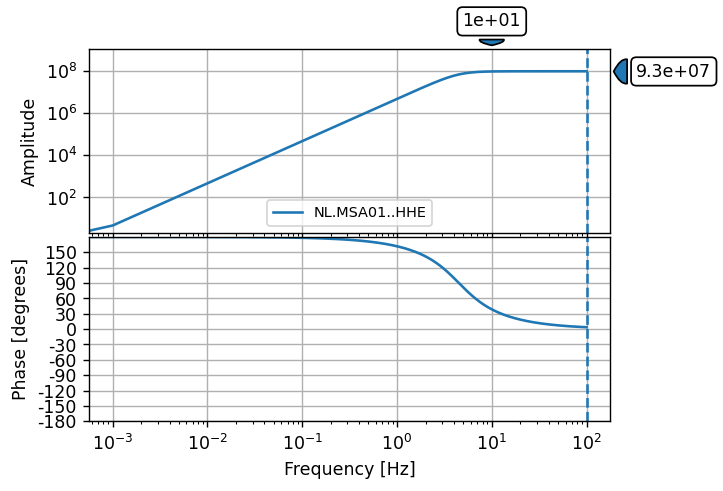

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26092e+07 defined at 10.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.35544e+06


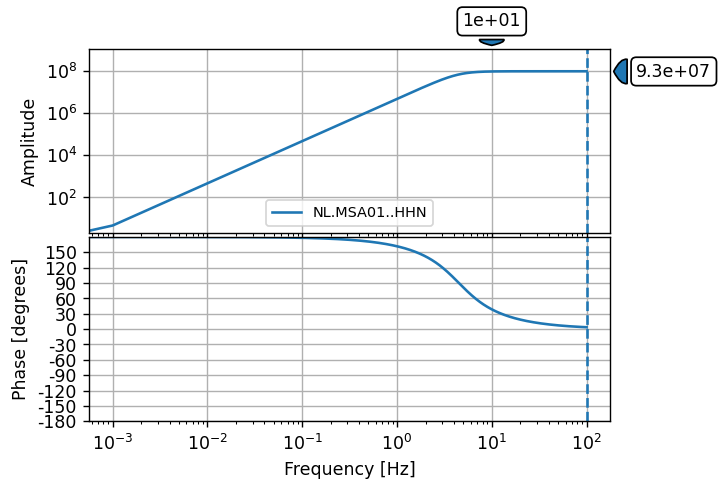

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26092e+07 defined at 10.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.35544e+06


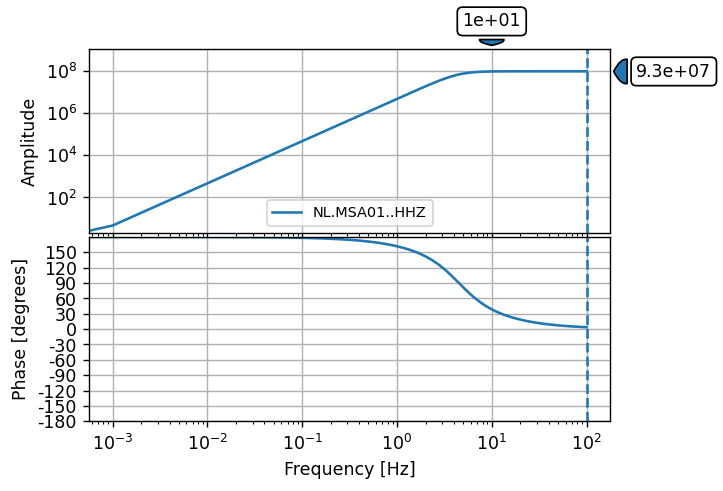

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 58720.3 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.14
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 419430


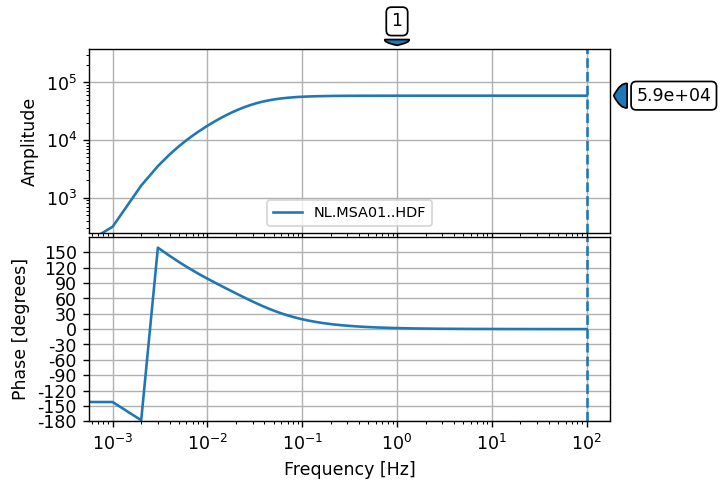

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26163e+07 defined at 10.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.3557e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26163e+07 defined at 10.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.3557e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


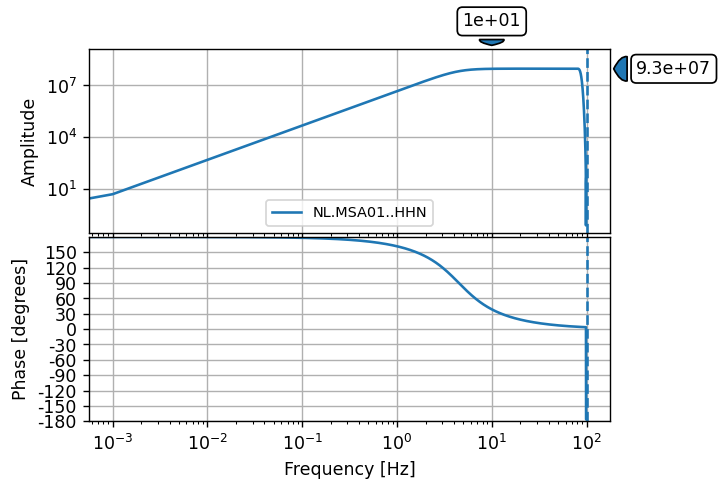

Channel Response
	From M/S (Meters per second) to COUNTS (Counts)
	Overall Sensitivity: 9.26163e+07 defined at 10.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 27.5997
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 3.3557e+06
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 58823.5 defined at 1.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.14
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 420168
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


In [16]:
for cha in sta:
    print(cha.response)
    fig=cha.plot(1e-3, unwrap_phase=True, label=cha.seed_id, plot_degrees=True)

We can do a side-by-side comparison too:

In [17]:
channels = sta.select(channel='HDF')
channel = channels[0]
channel_nrl = channels[1]

print(channel_nrl.response)

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 58823.5 defined at 1.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.14
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 420168
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


Now plot the result.

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 58720.3 defined at 1.000 Hz
	2 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.14
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 419430


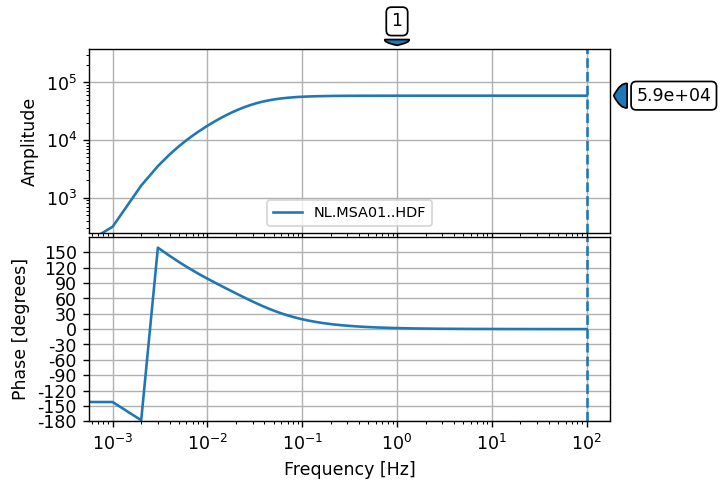

In [18]:
print(channel.response)
fig=channel.plot(1e-3, unwrap_phase=True, label=channel.seed_id, plot_degrees=True)

Channel Response
	From PA (Pascals) to COUNTS (Counts)
	Overall Sensitivity: 58823.5 defined at 1.000 Hz
	7 stages:
		Stage 1: PolesZerosResponseStage from PA to V, gain: 0.14
		Stage 2: ResponseStage from V to V, gain: 1
		Stage 3: CoefficientsTypeResponseStage from V to COUNTS, gain: 420168
		Stage 4: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 6: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1
		Stage 7: CoefficientsTypeResponseStage from COUNTS to COUNTS, gain: 1


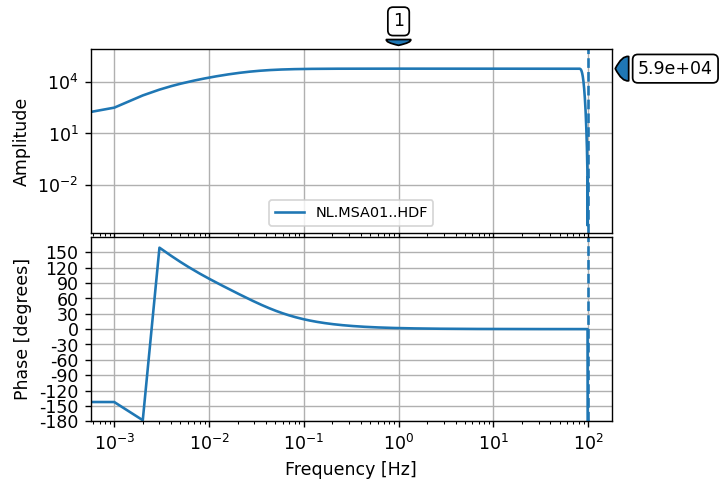

In [19]:
print(channel_nrl.response)
fig=channel_nrl.plot(1e-3, unwrap_phase=True, label=channel_nrl.seed_id, plot_degrees=True)

## Comparing response models

Now let's compare the different response curves that are saved in `channel` and `channel_nrl`. For that, it is best to define a convenience function `get_response_function`, which returns the complex-valued response function from an ObsPy `Channel` object:

In [20]:
def get_response_function(channel,min_freq):
    sampling_rate = channel.sample_rate
    nyquist = channel.sample_rate / 2.0
    nfft = int(sampling_rate / min_freq)
    t_samp = 1./sampling_rate
    cpx_response, freq = channel.response.get_evalresp_response(t_samp=t_samp, nfft=nfft, output='VEL')
    return(cpx_response,freq)

In [56]:
(H,f) = get_response_function(channel,1e-3)
(H_nrl,f) = get_response_function(channel_nrl,1e-3)

fig, ax = plt.subplots(2, sharex=True, figsize=(6, 3 ))
ax[0].set_title('Comparison NRL digitiser vs CoefficientsTypeResponseStage model')
ax[0].loglog(f,abs(H),linewidth=3.0,label='CoefficientsTypeResponseStage')
ax[0].loglog(f,abs(H_nrl),linewidth=1.0,label='NRL')
ax[0].set_ylim([1, 10e8])
ax[0].grid(which='both')
ax[0].legend()
ax[0].set(ylabel='Amplitude')


phase = np.angle(H, deg=True)
phase_nrl = np.angle(H, deg=True)
ax[1].semilogx(f,phase,linewidth=3.0,label='CoefficientsTypeResponseStage')
ax[1].semilogx(f,phase_nrl,linewidth=1.0,label='NRL')
ax[1].set_ylim([-180,180])
ax[1].grid(which='both')
ax[1].set(xlabel='Frequency (Hz)',ylabel='Phase (degrees)')

fig = plt.gcf()
# make room for title and colorbars
fig.subplots_adjust(bottom=0.05, top=0.85, left=0.1, right=1,
                    hspace=0.1)

fig.align_ylabels(ax)

plt.show()

As you can see both models are quite similar, except for the high-frequency cut-off above 80 Hz.

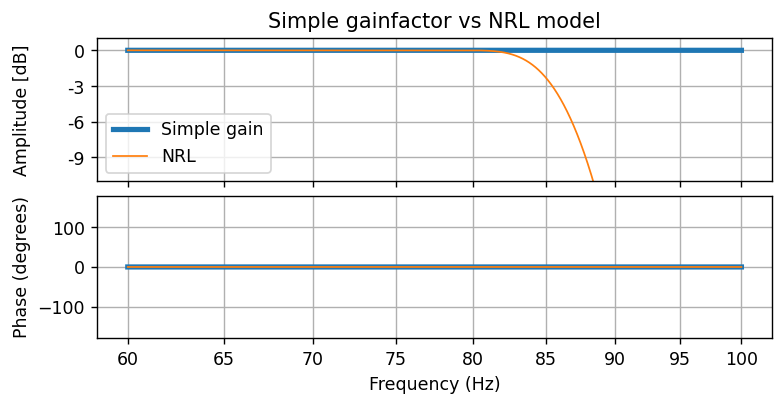

In [67]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter
#formatter = ScalarFormatter()
#formatter.set_scientific(False)
formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y))

(H,f) = get_response_function(channel,1e-3)
(H_nrl,f) = get_response_function(channel_nrl,1e-3)

f_idx = np.where(f>=60)
#print(f[f_idx])

f = f[f_idx]
H = H[f_idx]
H_nrl = H_nrl[f_idx]

fig, ax = plt.subplots(2, sharex=True, figsize=(6, 3 ))
ax[0].set_title('Simple gainfactor vs NRL model')
ax[0].semilogx(f,20*np.log10(abs(H)/max(abs(H))),linewidth=3.0,label='Simple gain')
ax[0].semilogx(f,20*np.log10(abs(H_nrl)/max(abs(H_nrl))),linewidth=1.0,label='NRL')
ax[0].grid(which='both')
#ax[0].set_ylim([-140, 20])
#ax[0].set_yticks(np.arange(-140,20,20))
ax[0].set_ylim([-11, 1])
ax[0].set_yticks(np.arange(-9, 3, 3))
ax[0].legend()
ax[0].set(ylabel='Amplitude [dB]')


phase = np.angle(H, deg=True)
phase_nrl = np.angle(H, deg=True)
ax[1].semilogx(f,phase,linewidth=3.0,label='CoefficientsTypeResponseStage')
ax[1].semilogx(f,phase_nrl,linewidth=1.0,label='NRL')
ax[1].set_ylim([-180,180])
ax[1].grid(which='both')
ax[1].set(xlabel='Frequency (Hz)',ylabel='Phase (degrees)')

ax[1].set_xticks(np.arange(60,105,5))

ax[0].yaxis.set_major_formatter(formatter)
ax[1].xaxis.set_major_formatter(formatter)

fig = plt.gcf()
# make room for title and colorbars
fig.subplots_adjust(bottom=0.05, top=0.85, left=0.1, right=1,
                    hspace=0.1)


fig.align_ylabels(ax)

plt.show()

# save to file
fid_figure = 'transfer_function_datalogger_2.png'
fig.savefig(fid_figure, bbox_inches="tight")

[  80.      80.001   80.002 ...,   99.998   99.999  100.   ]
